In [1]:
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from typing import Tuple
from datetime import datetime as dt
import torch.nn.functional as F
import random 
import torch.optim as optim
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


/home/luizp/projects/pibit/pibit/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
SEED = 1701
EPOCHS = 20
MODEL_REPO = "/home/luizp/projects/pibit/src/cleaner/cicClean.csv"
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

In [51]:
class ToImage:
    def __call__(self, array: torch.Tensor, keep_normalization=True):
        """ The idea is to convert a 1d array to a 2d array by resizing (with padding) to the square root of the 1d shape

        Ex: 
            - shape: 2048  
            - sqrt(shape) = 45.25 -> round to ceil (46)
            - resize the feature vector to 46x46 
            - return the new feature vector as a RGB PIL Image for torchvision transforms
         """
        #feat = array.shape[0]
        feat = array.shape[0]
        n = int(np.ceil(feat ** 0.5))

        array = array.cpu().numpy().copy()
        
        # Squared size with padding
        array.resize((n, n))
        if not keep_normalization:
            return (array * 255).astype(np.uint8)

        return torch.Tensor(array.astype(np.float32)).unsqueeze(0)

In [52]:
class CustomDataset(Dataset):
    """ Custom dataset class used for applying transforms to the features. """
    def __init__(self, subset: Tuple[torch.Tensor, torch.Tensor], transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[0][index], self.subset[1][index]
    
        if self.transform:
            x = self.transform(x)

        return x, y
        
    def __len__(self):
        return self.subset[0].size(0)

In [53]:
metrics = dict(tp=0, tn=0, fp=0, fn=0)
allmetrics = []


In [54]:
def validate(device: str, epoch: int, loss_fn, MODEL, dataset: DataLoader):
    # Validation
    MODEL.eval()
    it_eval = tqdm(enumerate(dataset), total=len(dataset))
    running_loss = 0.
    correct = 0
    qt = 1
    y_pred = list()
    y_true = list()
    with torch.no_grad():
        for _, (x, y) in it_eval:
            x = x.to(device)
            y = y.to(device)

            output = MODEL(x)
            running_loss += loss_fn(output, y).item()
            y_pred.extend(torch.argmax(output, 1).cpu().numpy())
            y_true.extend(y.data.cpu().numpy())
            correct += torch.sum(torch.argmax(output, 1).eq(y)).item()
            qt += len(x)
            desc = f"[{now()}] Epoch {str(epoch).zfill(3)} Val. Acc: {correct/qt:.4f} Val. Loss: {running_loss / len(dataset):.8f}"
            it_eval.set_description(desc)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics["tp"] = tp
    metrics["fp"] = fp
    metrics["tn"] = tn
    metrics["fn"] = fn
    return running_loss / len(dataset), correct/qt, metrics

In [55]:
def now():
    return dt.now().strftime("%d-%m-%Y %H-%M-%S")

In [56]:
def train(device: str, epoch: int, optimizer, loss_fn, MODEL, dataset: DataLoader):
    # Put the MODEL in the training mode
    MODEL.train()
    running_loss = 0.
    qt = 1
    correct = 0

    # Just add a fancy progress bar to the terminal...
    it = tqdm(enumerate(dataset), total=len(dataset))

    for _, (x, y) in it:
        x = x.to(device)
        y = y.to(device)
        
        # Make predictions for this batch
        outputs = MODEL(x)

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        loss = loss_fn(outputs, y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        correct += torch.sum(torch.argmax(outputs, 1).eq(y)).item()
        qt += len(x)
    
        # Gather data and report
        running_loss += loss.item()

        desc = f"[{now()}] Epoch {str(epoch).zfill(3)} Acc: {correct/qt:.4f} Loss: {running_loss / len(dataset):.8f}"
        it.set_description(desc)
    
    # Loss / Accuracy
    return running_loss / len(dataset), correct/qt

In [57]:
class InceptionModule(nn.Module):
    def __init__(self, in_channels, out1x1, red3x3, out3x3, red5x5, out5x5, pool_proj):
        super(InceptionModule, self).__init__()

        # 1x1 convolution branch
        self.branch1x1 = nn.Conv2d(in_channels, out1x1, kernel_size=1)

        # 1x1 convolution followed by 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, red3x3, kernel_size=1),
            nn.Conv2d(red3x3, out3x3, kernel_size=3, padding=1)
        )

        # 1x1 convolution followed by 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, red5x5, kernel_size=1),
            nn.Conv2d(red5x5, out5x5, kernel_size=5, padding=2)
        )

        # 3x3 max pooling followed by 1x1 convolution branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        # Concatenate the branches along the channel dimension
        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)

class GoogleNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GoogleNet, self).__init__()

        # Initial convolution layers
        self.conv1 = nn.Conv2d(1, 128, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception modules
        self.inception1 = InceptionModule(128, 128, 128, 128, 32, 32, 32)
        self.inception2 = InceptionModule(320, 128, 192, 192, 96, 96, 64)

        # ...

        # You can add more Inception modules as needed

        # Final fully connected layer
        self.fc = nn.Linear(480, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.inception1(x)
        x = self.inception2(x)

        # ...

        # You can add more Inception modules as needed

        # Global average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)

        # Final fully connected layer
        x = self.fc(x)
        return x

In [58]:
torch.cuda.is_available()

True

In [59]:
def no_update():
    # Reproducibility
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)

    MODEL = GoogleNet().to('cuda')

    #if MODEL is None or not isinstance(nn.Module):
    #    raise TypeError("The model does not exist or isn't an instance of nn.Module (PyTorch)")
    
    transform = transforms.Compose([
        ToImage(),
    ])
    csv_path = "/home/luizp/projects/pibit/src/cleaner/cicClean.csv"
    df = pd.read_csv(csv_path)
    y = df.iloc[:, -1].values
    x = df.iloc[:, :-1].values
    y = y[::-1]
    x = np.squeeze(x)
    #x = x.reshape((1, -1))
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.1, random_state=42
    )

    #raise Exception("Precisa carregar e separar (treino, validação e teste) um dataset qualquer para executar")
    x_train = torch.Tensor(x_train)
    y_train = torch.LongTensor(y_train)
    x_test  = torch.Tensor(x_test)
    y_test  = torch.LongTensor(y_test)
    #x_val   = torch.Tensor(x_val)
    #y_val   = torch.LongTensor(y_val)

    # A parte de fazer o reshape está quando passo uma transformada (ToImage()) como parâmetro
    cd_train = CustomDataset(subset=(x_train, y_train), transform=transform)
    cd_test  = CustomDataset(subset=(x_test, y_test), transform=transform)
    #cd_val   = CustomDataset(subset=(X_val, y_val), transform=transform)

    data_train = DataLoader(cd_train, shuffle=True, batch_size=BATCH_SIZE, num_workers=8)
    data_test  = DataLoader(cd_test, shuffle=True, batch_size=BATCH_SIZE, num_workers=8)
    #data_val   = DataLoader(cd_val, shuffle=True, batch_size=BATCH_SIZE, num_workers=8)

    loss_fn   = nn.CrossEntropyLoss()
    optimizer = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE)

    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train(device, epoch, optimizer, loss_fn, MODEL, data_train)
        #val_loss, val_acc, _ = validate(device, epoch, optimizer, loss_fn, MODEL, data_val)

        _, _, allmetrics.append(validate(device, epoch, loss_fn, MODEL, data_test))
        print(metrics)


In [60]:
if __name__ == "__main__":
    no_update()
    print("Finished experiment!")

cuda


[07-02-2024 00-55-22] Epoch 001 Acc: 0.9966 Loss: 0.01140767: 100%|██████████| 7032/7032 [04:08<00:00, 28.35it/s]
[07-02-2024 00-55-34] Epoch 001 Val. Acc: 0.9989 Val. Loss: 0.00321662: 100%|██████████| 782/782 [00:11<00:00, 69.73it/s]

{'tp': 49885, 'tn': 50003, 'fp': 48, 'fn': 64}



[07-02-2024 00-59-46] Epoch 002 Acc: 0.9989 Loss: 0.00442416: 100%|██████████| 7032/7032 [04:10<00:00, 28.02it/s]
[07-02-2024 00-59-58] Epoch 002 Val. Acc: 0.9993 Val. Loss: 0.00252739: 100%|██████████| 782/782 [00:11<00:00, 69.52it/s]

{'tp': 49897, 'tn': 50031, 'fp': 20, 'fn': 52}



[07-02-2024 01-04-09] Epoch 003 Acc: 0.9992 Loss: 0.00297496: 100%|██████████| 7032/7032 [04:10<00:00, 28.03it/s]
[07-02-2024 01-04-21] Epoch 003 Val. Acc: 0.9995 Val. Loss: 0.00176509: 100%|██████████| 782/782 [00:11<00:00, 70.12it/s]

{'tp': 49921, 'tn': 50034, 'fp': 17, 'fn': 28}



[07-02-2024 01-08-34] Epoch 004 Acc: 0.9994 Loss: 0.00285901: 100%|██████████| 7032/7032 [04:11<00:00, 27.97it/s]
[07-02-2024 01-08-45] Epoch 004 Val. Acc: 0.9994 Val. Loss: 0.00189335: 100%|██████████| 782/782 [00:11<00:00, 70.44it/s]


{'tp': 49904, 'tn': 50040, 'fp': 11, 'fn': 45}


[07-02-2024 01-12-57] Epoch 005 Acc: 0.9995 Loss: 0.00226569: 100%|██████████| 7032/7032 [04:11<00:00, 28.00it/s]
[07-02-2024 01-13-09] Epoch 005 Val. Acc: 0.9997 Val. Loss: 0.00120447: 100%|██████████| 782/782 [00:11<00:00, 69.61it/s]

{'tp': 49935, 'tn': 50039, 'fp': 12, 'fn': 14}



[07-02-2024 01-17-21] Epoch 006 Acc: 0.9996 Loss: 0.00196026: 100%|██████████| 7032/7032 [04:11<00:00, 28.01it/s]
[07-02-2024 01-17-33] Epoch 006 Val. Acc: 0.9997 Val. Loss: 0.00124562: 100%|██████████| 782/782 [00:11<00:00, 69.73it/s]

{'tp': 49934, 'tn': 50032, 'fp': 19, 'fn': 15}



[07-02-2024 01-21-45] Epoch 007 Acc: 0.9996 Loss: 0.00221227: 100%|██████████| 7032/7032 [04:10<00:00, 28.02it/s]
[07-02-2024 01-21-57] Epoch 007 Val. Acc: 0.9998 Val. Loss: 0.00102548: 100%|██████████| 782/782 [00:11<00:00, 69.18it/s]

{'tp': 49941, 'tn': 50039, 'fp': 12, 'fn': 8}



[07-02-2024 01-26-09] Epoch 008 Acc: 0.9996 Loss: 0.00173158: 100%|██████████| 7032/7032 [04:11<00:00, 28.00it/s]
[07-02-2024 01-26-21] Epoch 008 Val. Acc: 0.9997 Val. Loss: 0.00117570: 100%|██████████| 782/782 [00:11<00:00, 69.68it/s]

{'tp': 49932, 'tn': 50039, 'fp': 12, 'fn': 17}



[07-02-2024 01-30-33] Epoch 009 Acc: 0.9996 Loss: 0.00211549: 100%|██████████| 7032/7032 [04:10<00:00, 28.03it/s]
[07-02-2024 01-30-45] Epoch 009 Val. Acc: 0.9997 Val. Loss: 0.00128101: 100%|██████████| 782/782 [00:11<00:00, 69.68it/s]


{'tp': 49934, 'tn': 50039, 'fp': 12, 'fn': 15}


[07-02-2024 01-34-56] Epoch 010 Acc: 0.9996 Loss: 0.00170071: 100%|██████████| 7032/7032 [04:11<00:00, 28.00it/s]
[07-02-2024 01-35-09] Epoch 010 Val. Acc: 0.9998 Val. Loss: 0.00079165: 100%|██████████| 782/782 [00:11<00:00, 68.97it/s]

{'tp': 49942, 'tn': 50041, 'fp': 10, 'fn': 7}



[07-02-2024 01-39-20] Epoch 011 Acc: 0.9996 Loss: 0.00179312: 100%|██████████| 7032/7032 [04:10<00:00, 28.04it/s]
[07-02-2024 01-39-32] Epoch 011 Val. Acc: 0.9999 Val. Loss: 0.00071823: 100%|██████████| 782/782 [00:11<00:00, 69.40it/s]

{'tp': 49949, 'tn': 50038, 'fp': 13, 'fn': 0}



[07-02-2024 01-43-44] Epoch 012 Acc: 0.9997 Loss: 0.00130723: 100%|██████████| 7032/7032 [04:11<00:00, 27.99it/s]
[07-02-2024 01-43-56] Epoch 012 Val. Acc: 0.9997 Val. Loss: 0.00084915: 100%|██████████| 782/782 [00:11<00:00, 69.03it/s]

{'tp': 49932, 'tn': 50042, 'fp': 9, 'fn': 17}



[07-02-2024 01-48-08] Epoch 013 Acc: 0.9997 Loss: 0.00218625: 100%|██████████| 7032/7032 [04:10<00:00, 28.04it/s]
[07-02-2024 01-48-20] Epoch 013 Val. Acc: 0.9997 Val. Loss: 0.00097571: 100%|██████████| 782/782 [00:11<00:00, 69.07it/s]

{'tp': 49927, 'tn': 50043, 'fp': 8, 'fn': 22}



[07-02-2024 01-52-32] Epoch 014 Acc: 0.9997 Loss: 0.00205210: 100%|██████████| 7032/7032 [04:11<00:00, 28.00it/s]
[07-02-2024 01-52-44] Epoch 014 Val. Acc: 0.9996 Val. Loss: 0.00241648: 100%|██████████| 782/782 [00:11<00:00, 68.89it/s]

{'tp': 49941, 'tn': 50020, 'fp': 31, 'fn': 8}



[07-02-2024 01-56-56] Epoch 015 Acc: 0.9997 Loss: 0.00173982: 100%|██████████| 7032/7032 [04:11<00:00, 28.00it/s]
[07-02-2024 01-57-08] Epoch 015 Val. Acc: 0.9999 Val. Loss: 0.00083065: 100%|██████████| 782/782 [00:11<00:00, 69.32it/s]


{'tp': 49948, 'tn': 50043, 'fp': 8, 'fn': 1}


[07-02-2024 02-01-20] Epoch 016 Acc: 0.9997 Loss: 0.00422216: 100%|██████████| 7032/7032 [04:11<00:00, 28.01it/s]
[07-02-2024 02-01-32] Epoch 016 Val. Acc: 0.9998 Val. Loss: 0.00181993: 100%|██████████| 782/782 [00:11<00:00, 69.04it/s]

{'tp': 49942, 'tn': 50041, 'fp': 10, 'fn': 7}



[07-02-2024 02-05-44] Epoch 017 Acc: 0.9998 Loss: 0.00125033: 100%|██████████| 7032/7032 [04:10<00:00, 28.02it/s]
[07-02-2024 02-05-56] Epoch 017 Val. Acc: 0.9998 Val. Loss: 0.00081691: 100%|██████████| 782/782 [00:11<00:00, 68.84it/s]

{'tp': 49942, 'tn': 50040, 'fp': 11, 'fn': 7}



[07-02-2024 02-10-08] Epoch 018 Acc: 0.9997 Loss: 0.00193376: 100%|██████████| 7032/7032 [04:11<00:00, 28.01it/s]
[07-02-2024 02-10-20] Epoch 018 Val. Acc: 0.9998 Val. Loss: 0.00128106: 100%|██████████| 782/782 [00:11<00:00, 68.88it/s]

{'tp': 49949, 'tn': 50033, 'fp': 18, 'fn': 0}



[07-02-2024 02-14-32] Epoch 019 Acc: 0.9998 Loss: 0.00126280: 100%|██████████| 7032/7032 [04:11<00:00, 28.00it/s]
[07-02-2024 02-14-44] Epoch 019 Val. Acc: 0.9999 Val. Loss: 0.00055612: 100%|██████████| 782/782 [00:11<00:00, 68.61it/s]

{'tp': 49948, 'tn': 50042, 'fp': 9, 'fn': 1}



[07-02-2024 02-18-56] Epoch 020 Acc: 0.9997 Loss: 0.00168077: 100%|██████████| 7032/7032 [04:11<00:00, 27.98it/s]
[07-02-2024 02-19-08] Epoch 020 Val. Acc: 0.9997 Val. Loss: 0.00637005: 100%|██████████| 782/782 [00:11<00:00, 69.07it/s]


{'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}
Finished experiment!


In [63]:
allmetrics

[(0.0032166186901938726,
  0.998870011299887,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.002527386884239581,
  0.999270007299927,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.0017650877341752315,
  0.999540004599954,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.0018933534413803537,
  0.999430005699943,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.0012044725710793232,
  0.999730002699973,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.0012456204718011945,
  0.999650003499965,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.0010254835426174098,
  0.999790002099979,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.0011756976698257006,
  0.99970000299997,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.0012810077465436806,
  0.999720002799972,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.0007916483731645638,
  0.999820001799982,
  {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}),
 (0.0007182303805296925,
  0.999

In [64]:
allmetrics2=[]
for i in allmetrics:
    allmetrics2.append(i[2])

print(allmetrics2)

[{'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}, {'tp': 49933, 'tn': 50040, 'fp': 11, 'fn': 16}]


In [65]:
allmetrics2[1]['fn']

16

In [70]:
fpr = []
tpr = []
for i in allmetrics2:
    fpr.append(i['fp']/(i['fp']+i['fn']))
    tpr.append(i['tp']/(i['tp']+i['tn']))

In [74]:
fpr

[0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074,
 0.4074074074074074]

In [75]:
tpr

[0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796,
 0.49946485551098796]

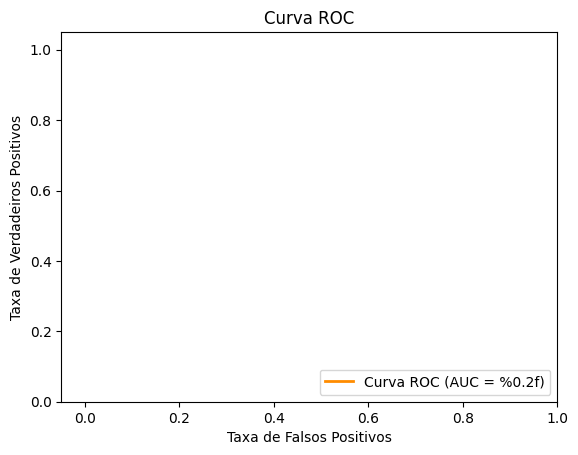

In [83]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)')
#plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()